##### This Python 3 environment comes with many helpful analytics libraries installed
##### It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
##### For example, here's several helpful packages to load in

##### another ref that you can use is : https://github.com/glample/tagger/blob/master/model.py

In [144]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

os.chdir("/home/jovyan/work/LSTM")
import lstmFun

In [106]:
from subprocess import check_output
print(check_output(["ls", "/home/jovyan/work/data/label_data"]).decode("utf8"))

digitoday.2014.csv
digitoday.2014.dev.csv
digitoday.2014.train.csv
digitoday.2015.test.csv
ner.csv
wikipedia.test.csv



In [145]:
dframe = pd.read_csv("/home/jovyan/work/data/label_data/ner.csv")
# dframe = pd.read_csv("/home/jovyan/work/data/label_data/digitoday.2014.train.csv",on_bad_lines='skip',delimiter='\t',names=['word', 'tag', 'unnamed'])
dframe.head(30)

,Unnamed: 0,sentence_idx,shape,word,tag
0,0,1.0,capitalized,Thousands,O
1,1,1.0,lowercase,of,O
2,2,1.0,lowercase,demonstrators,O
3,3,1.0,lowercase,have,O
4,4,1.0,lowercase,marched,O
5,5,1.0,lowercase,through,O
6,6,1.0,capitalized,London,B-geo
7,7,1.0,lowercase,to,O
8,8,1.0,lowercase,protest,O
9,9,1.0,lowercase,the,O


In [150]:
dframe = lstmFun.add_sentence_id_column(dframe)

AttributeError: module 'lstmFun' has no attribute 'add_sentence_id_column'

In [113]:
sentences, get_next = lstmFun.get_sentences(dframe)

In [114]:
maxlen = lstmFun.get_max_len(sentences)
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 121


In [115]:
# Check how long sentences are so that we can pad them
plt.style.use("ggplot")

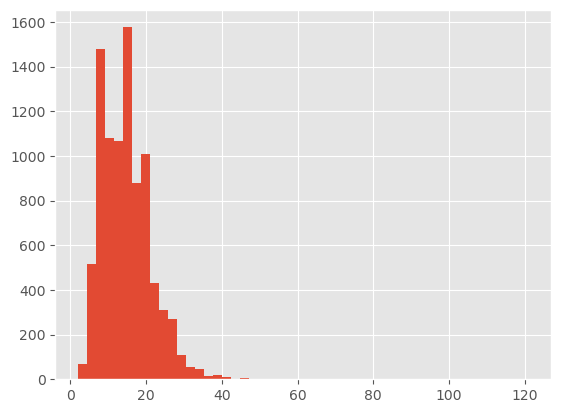

In [116]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [117]:
words = list(set(dframe["word"].values))
words.append("ENDPAD")

In [118]:
n_words = len(words); n_words

36632

In [119]:
tags = list(set(dframe["tag"].values))
tags

['I-EVENT',
 'B-ORG',
 'B-DATE',
 'I-DATE',
 'O',
 'B-EVENT',
 'I-LOC',
 'I-PRO',
 'B-PER',
 'B-LOC',
 'B-PRO',
 'I-PER',
 'I-ORG']

In [120]:
n_tags = len(tags); n_tags

13

In [121]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [122]:
word2idx['Obama']

5767

In [123]:
tag2idx["O"]

4

In [124]:
# import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [125]:
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [126]:
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

In [127]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [128]:
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])

In [129]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [130]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [131]:
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [132]:
input = Input(shape=(maxlen,))
model = Embedding(input_dim=n_words, output_dim=maxlen, input_length=maxlen)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

In [133]:
model = Model(input, out)

In [134]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [135]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=1, validation_split=0.2, verbose=1)

180/180 [==============================] - 37s 188ms/step - loss: 0.1659 - accuracy: 0.9839 - val_loss: 0.0746 - val_accuracy: 0.9844


In [136]:
dir = "/home/jovyan/work/data/output/LSTMmodel"
model.save(dir)

2023-05-20 17:45:43.735656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'while/Placeholder_2' with dtype float and shape [?,100]
	 [[{{node while/Placeholder_2}}]]
2023-05-20 17:45:43.809657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'while/Placeholder_2' with dtype float and shape [?,100]
	 [[{{node while/Placeholder_2}}]]
2023-05-20 17:45:43.861059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and 

INFO:tensorflow:Assets written to: /home/jovyan/work/data/output/LSTMmodel/assets


INFO:tensorflow:Assets written to: /home/jovyan/work/data/output/LSTMmodel/assets


In [137]:
i = 0
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:14} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:14}: {}".format(words[w],tags[pred]))

1/1 [==============================] - 1s 504ms/step
Word           (True ): Pred
Googlelle     : O
tämä          : O
syy           : O
ei            : O
kelvannut     : O
,             : O
sillä         : O
yhtiön        : O
noudattama    : O
90            : O
päivän        : O
ennakkoilmoitusaika: O
tuli          : O
täyteen       : O
,             : O
ja            : O
Google        : O
julkisti      : O
aukon         : O
.             : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD        : O
ENDPAD       

In [138]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 121)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 121, 121)          4432472   
                                                                 
 dropout_1 (Dropout)         (None, 121, 121)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 121, 200)         177600    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 121, 13)          2613      
 tributed)                                                       
                                                                 
Total params: 4,612,685
Trainable params: 4,612,685
Non-tra

In [139]:
# Evaluation
loss, accuracy = model.evaluate(X_test, np.array(y_test))
print("Loss: {:.4f}".format(loss))
print("Accuracy: {:.2f}%".format(accuracy * 100))

56/56 [==============================] - 2s 34ms/step - loss: 0.0762 - accuracy: 0.9838
Loss: 0.0762
Accuracy: 98.38%


In [140]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [141]:

y_pred = model.predict(X_test)
y_pred_indices = np.argmax(y_pred, axis=-1)

# Flatten the true and predicted labels
y_true_flattened = np.argmax(y_test, axis=-1).flatten()
y_pred_flattened = y_pred_indices.flatten()

# Calculate precision
precision = precision_score(y_true_flattened, y_pred_flattened, average='weighted')

# Calculate recall
recall = recall_score(y_true_flattened, y_pred_flattened, average='weighted')

# Calculate F1 score
f1 = f1_score(y_true_flattened, y_pred_flattened, average='weighted')

# Calculate accuracy
accuracy = accuracy_score(y_true_flattened, y_pred_flattened)

# Print the evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Accuracy:", accuracy)

56/56 [==============================] - 2s 32ms/step
Precision: 0.9677687809052494
Recall: 0.9837523981700118
F1 Score: 0.9756951339270009
Accuracy: 0.9837523981700118


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
